# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

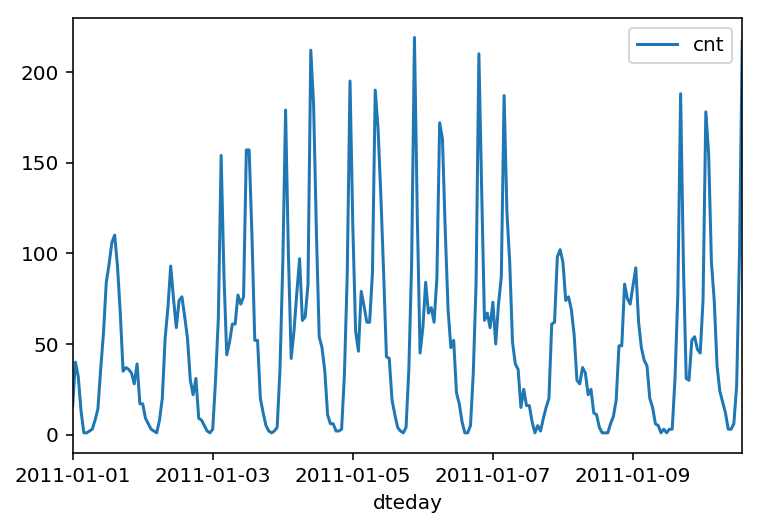

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
columns_lst = data.columns.tolist() 
columns_lst

['yr',
 'holiday',
 'temp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'weathersit_1',
 'weathersit_2',
 'weathersit_3',
 'weathersit_4',
 'mnth_1',
 'mnth_2',
 'mnth_3',
 'mnth_4',
 'mnth_5',
 'mnth_6',
 'mnth_7',
 'mnth_8',
 'mnth_9',
 'mnth_10',
 'mnth_11',
 'mnth_12',
 'hr_0',
 'hr_1',
 'hr_2',
 'hr_3',
 'hr_4',
 'hr_5',
 'hr_6',
 'hr_7',
 'hr_8',
 'hr_9',
 'hr_10',
 'hr_11',
 'hr_12',
 'hr_13',
 'hr_14',
 'hr_15',
 'hr_16',
 'hr_17',
 'hr_18',
 'hr_19',
 'hr_20',
 'hr_21',
 'hr_22',
 'hr_23',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [7]:
data.shape

(17379, 59)

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [8]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [9]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [10]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [11]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1/(1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = X.dot(self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = hidden_outputs.dot(self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            output_error_term = error
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = output_error_term.dot(self.weights_hidden_to_output.T)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        
            
        hidden_inputs = features.dot(self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
            # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = hidden_outputs.dot(self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [12]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [13]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))
    
    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.045s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [17]:
import sys

### Set the hyperparameters here ###
iterations = 100
learning_rate = 0.2
hidden_nodes = 3
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    print (batch)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

[ 6035  8948  3813  6211  4793 12697  6751 14663  3435 13164 12222 12018
  8707  3483  9208  6017 14658  6007  2263 14615 10520 12164  9239  7893
  7134  1010  3278  1386  7351  2655  4941  5688 13280  6288 10859 14857
  5223  3575   292 14259   370 13825 15233  1319  5966 14796  1079   383
  2613  1449 13178  7676    63  8425 13284  1433 15418  5936 12720  3690
  5476  7529   184  3178 10874  9321  7299 12214   493  8072  8135 11417
 15417  3686 12858  7340  5221  4902  8984  1719  8531  2375   480  4094
  9962 11749  2424  4163 14731  9716   656  4106 11185 12271  4836  7094
  9941  1468  8171   608   502   234  7638  7415 11734  8612  4919  8987
  3663 13388  8668 10391  9762  5223   525  2499  5595 13803   568  5067
  1774  6413  9551 10680 15161 13067 15401 11853]
Progress: 0.0% ... Training loss: 0     ... Validation loss: 15435[ 8416  1656  6106   917  3040 12674 12811 10216  1254  6686  2933  1709
  3119  1523 14562  7445  6746   759 15298  8739  7360  8627  3208  7385
 12015 1

Progress: 9.0% ... Training loss: 0     ... Validation loss: 15435[14815 12497 15378  6529  9476  1841 14530 14979 10827    38  8155  3010
  1815  5432  2156  6482  4010 13478 13542  9138  7888  1915  2417  6060
  2656 12577 11639  1696 11519    20  2497  4538  9055 14104 15151    27
 15186 14240 11851  1413  2642 13285  7548  8058 15152  3889  4028 11925
  3936  4062  6710  3942  6306 11223  2952  2529  1857  5571 11317  5056
  4167  7058 13069  6341 15146 10978  5809  2171  8992 12228 13240   424
  6269  1892  5939  3298  3544 12228 13822 13027   677  2841  3044 13635
 15133 11382  2454 11517  7824  3781 11424 14629  2525  9552  1489  1377
  1491  6923  2944  7425  8541  2494   520 14502 11203 10462 11957 13421
 12013  2746  3130  1811  9861  4000 13115 10207  6613  2182 12444 13950
 14021  7442  3484  6198 11977  7376  6367  8907]
Progress: 10.0% ... Training loss: 0     ... Validation loss: 15435[13901  4306  2444 12341  8968  6980 12101  9314  3177  2876 10340 10210
 10320  8210 1

Progress: 19.0% ... Training loss: 0     ... Validation loss: 15435[ 9928 13497 10222  6424  7672 11680  7107 14957  7000 13937 14081  2115
 15352 12433  5413  3764  1992  8539  7213   577  4713 13803  9518  2931
  3970    49 12967  9653  7175  8345  6016 14202  5810 14761  6187 13704
 12216  9716  7950   386  9782  1769  2517  4628  3463  2021  7184 12652
  7582   783   603  4957  8603  1855 11724 14576  5551  5741  2861 10048
 15287  3699 14872  6354  8573 11133  1078  5281 15162  8808  8333  2462
 14032 10420 12430 11447   980 10734  2240 13744  9080 11752  5651  7059
   983  2478  8702  3809   189 10320 10848  6184  3398 13644  3110 12641
  2926  4713  2867  6182  4147  3030  6924  6050 14339   278  4893  5194
  4552 15304  2421  6387  9728  9380 11522  9031  3873 15301  9121  5866
 13316   453 11543 15046 12853  7018  9309 11076]
Progress: 20.0% ... Training loss: 0     ... Validation loss: 15435[ 6362  1652  3436  5319  8313  9586  9704  3260  3923  1916  2163  8235
  2346  2850 

Progress: 29.0% ... Training loss: 0     ... Validation loss: 15435[ 8961 14397 10734  3850  9027  6144  3628  4273   934  1638  8994  4921
 10654 12954 10403  8765  4748  6152 10746 12128  5972  2400   228  9588
  3192 14187   355 14267 15252  8405 14703 10723 10818 12706  3506 10903
 13295  7784  1562  7251 14987 11204  6189   451  1907  8212 15244  2835
  8224  7050   857 10781  2805 11261 13440 15321 11239 10540 11834  7453
 10983  1282  5830  8888   842  8424  8166  1740  9364   192  8875   523
  7750  5011  5255   120  5335 11482  6320  6900 15314  4102  5699  2103
  6144  6582  9563  2641   400 10332 10456 11003 12755  4690 10520  4759
  1204  3335 12178  7021   566  1221   613 10478 11925  4538  7886  9415
  4126 13246  9231  1640  9447  9790  2827 15288  5607 14173 14052  6264
  6232  2589  1847  6115  6256 11175  9421  8027]
Progress: 30.0% ... Training loss: 0     ... Validation loss: 15435[12087 11946 12742  5829  6866  2294 11168 11550 14636 12088    41  4762
  9107  2692 

Progress: 39.0% ... Training loss: 0     ... Validation loss: 15435[15225 11442  9428 12479 13826   208 12827  7158  9994 12211  6550  7679
  8340 10595  7498 15100 14218 14098  6575 12925  1477  7383 14319  8192
  2102 10172  6244  6180  9449  2756  3285  4077 15250  4967  8264  9813
  8938  1166  5090  9348 10179  1686   738  5737 13898  4317  1060  7215
  4222 10982  6754  1867  3270  5779  2741  4137  9039 12487  6942 11434
   869  1465 13885 14584 12807  9830  1182  9825 13416  5934 11747 11327
 12098  8364 13892   969  6810  8216   675  4773  3689  5400  4189  2482
 10269  7861  1579  9423 14408  6058 14998  3381 12918 12569  8844  1937
 12902 15137  3927  4272  7439 15198 14425  6418 10038  6710  4613  4890
  7840 10269 13240 11159   262 10369 15278   882 14278 12640 15359  8565
 10252  6269   727  9512 13390 12993  7091 10283]
Progress: 40.0% ... Training loss: 0     ... Validation loss: 15435[ 4607 12148 10809  1284  9823  2380 14177 11079 13170 14193  4409  2950
  3842  4276 

Progress: 49.0% ... Training loss: 0     ... Validation loss: 15435[14515  4782  7606   354  9309 15320  5719   687  3365 10470  8386  3605
 12279 14605 11901   804  5209  5397 14671  5373  4515 15302  2147  6657
  9828   861  7522  5385  9809  8556 14053 11737  6302 12770 12415  9563
 12345 12290  2052  3329  5868   122    16  6359 14986  2428  1204   655
  9849  4866  5905  6396  2172  8979  8313  4135   174  8365  9562 12070
  2361  9410 12085  2733  4518 14041 10327  8183 13821 11793  5284 11272
  8142  5814  8926 11003  2459  2108  5691  9761   261 14708 12284 13931
  9731  5945 11397  9218   311  6519  7627  9980  5379  2465  5728 13498
 13391 15390 12281 11368  7044  7687  3885  2010  3469  1029  1616  9751
  1424  2696 14787 13273  9000  6622  3230 12027   745  4134 12537  1035
  2737  5025 12683  1018  6137  7443  5109  4899]
Progress: 50.0% ... Training loss: 0     ... Validation loss: 15435[  484  4345 13899  3496 11374 10341  9482 11759  2831  6048  6434 12427
  2939 14293 

Progress: 59.0% ... Training loss: 0     ... Validation loss: 15435[  455 14274  6722 13441 10623 14124  4434 10379   631  8542  2019 10564
  4381 10056  4657 10535  1957 14775  8317 11560 10264  7809  5162  8418
 11501 10444  5156 15357  3477 12499  1593  1466  5366 13311  7491 14950
  4629  5268  3768  5836 11204  8767 11328  4998  9873  7772  6132 10264
 11856  6943  8891  1110  5808  6707 11179  2190 14278 14730  3610 12026
 11573  3869  6324  9258  5979 13912  8079  9886 15293 15303  6882  9589
  7673 11792 14040  5594 13729  7538 11914 10358 12535  7520 10482 11176
  3215  7886  6643 11546  8847   455 11410  6691  8022  3646 10732  2806
  3913  9156 10947  2840   812  1638 11650  5169 12108 14032  3875   397
  4878  9346 15069 13115  6757  1562 12031  6407 10537 10753  3536  9982
   790  1680 13946  8198  4828  2598 15091 12060]
Progress: 60.0% ... Training loss: 0     ... Validation loss: 15435[13372  5059   205   667  7549  9691  7558 13197   594 11756 10428 15034
  7783  2751 

Progress: 69.0% ... Training loss: 0     ... Validation loss: 15435[ 7381  9171 13022  4652  5757  3353 10322  9766 12407  7002  7330  6437
 11276 10407  7619  4741  2754  3281  7386  8672 14685  9122 12636  5409
 14517  4188  6462  3581 10739 15027  4362 14137  2122  2672  8628  2204
  3338 12476  1822  6343   538  2717 12746  5831   338  1383  4741 11395
  6622 11229  2825  8204  5706  4474  3470  3316  9700 12772 10195  4773
  9116  8026  9222 12073  7157 10325  6207  1975 11384 12049  7073  5994
   837 11111 10614  5907   125   544  2091  3141  8168  2081 11938 14213
  8463  5510  6176  4096   891   225 11316  3798 11240 14817 13233 11116
 12748  5297  4424  7547   965  4291  8056  5629  1742  2015  1440  5250
  5430  9875  2165  9245  4401 13399   844 14342  4006  1117  6331  2309
  3314    83  8459 13465  6883  8357  5927 13554]
Progress: 70.0% ... Training loss: 0     ... Validation loss: 15435[14517 14854  1328  6621  4374  6057  2484  5112  9682  1249   422 13837
 13137 10950 

Progress: 79.0% ... Training loss: 0     ... Validation loss: 15435[11022  9739  7457 14663 13623  2514  7198  8704  9941  5635 13233 12512
    82  2033  9022  5299  8082  8479 14314  5638  9520   391  3991  7614
  7931  1563  4685   672 13369  9761  3756  1928  1394  8523  2088 11282
  3574  3372  4382  5779  5774  4309  5637  3260 11542 12355   678  6109
  7095 12922 14718 15074  3011   770  9870  6580 14351 14985 12877  1297
  2919 10001 15289  5597  6014  9346  4406  9234  3264  2601 11743 10192
  6020  6461  1908  7266  6878  7950 13697  2338  8144 11513  8227  1237
 10650  7346  7428  5042 11258  4698  8434  1572 10377  5350  4235  9215
 14163  2522  8463  3456 14922 15248  1762 10472 12897 11225  3078 12086
  2894    22  6714  8721 13744  7515  9390  5663 13426  3594  5943 11118
  7127 12685  4436  7649  2469 12267  4255   375]
Progress: 80.0% ... Training loss: 0     ... Validation loss: 15435[ 1049    77 12682  7874 14527 13166   624  1575 14391  8367  5790 12393
  6908  4061 

Progress: 89.0% ... Training loss: 0     ... Validation loss: 15435[ 9405  4039  3133 11608  1971 14172   338 12089  6853  9435 13392  6070
  3144   987  4215 14702 12041 12973 10228 12413 12404  3099 14563  2017
 13845  3119  1443  2368  6522  4120  5898   531   965 14251 13149 13556
  5281  5449  4712  4951 15153   857 10889 10433   156 14919  6655  7558
 10316 14098  5596 14214  7755  1562 12449  7856 11290  4131 11146 10739
 14522  5958  4269 12834 14304 12926  4823  3482  2097  3683 13492  4464
 13887   193  5465 12711  8090 12931  1172 13443 13945 10310  3641  3144
  6865  9888  8881 10027   427   426   621 13069 13759  6512  7633 15202
  4851  2424  2384  1712 13713 10647   216  7447 14449 13211 12226  8232
  9326  1566  5902  2555 10910 10842  7543  1858  7693  8372  6018  8961
  3906  9509  9467  3804  1363  3369  4229  7394]
Progress: 90.0% ... Training loss: 0     ... Validation loss: 15435[13000 13255  1108 12518  7155  3611 15249 14612  8574  4623 12812  7331
  4152 11683 

Progress: 99.0% ... Training loss: 0     ... Validation loss: 15435

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

KeyError: 0

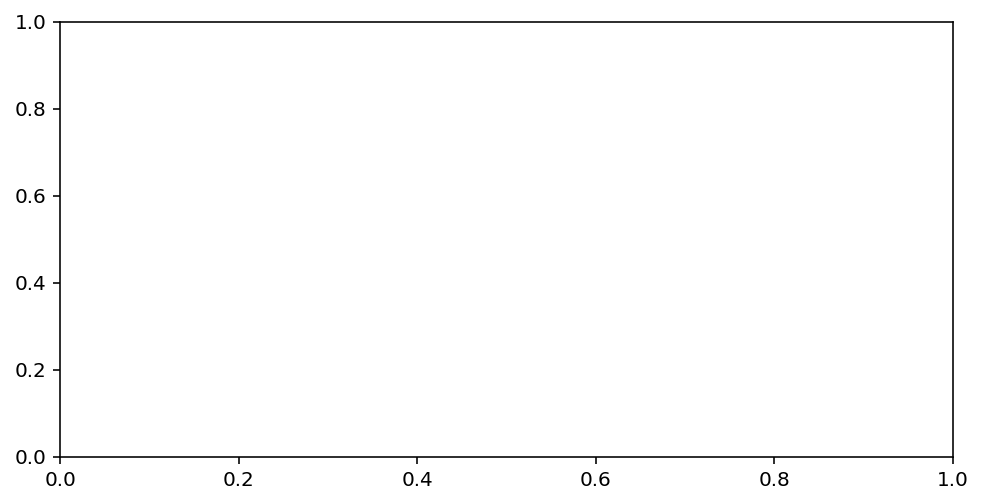

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below